### Importing Modules and Loading Data

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [2]:
num_workers = 0
batch_size = 36
valid_size = 0.2

# Data augmentation for train data + conversion to tensor
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
   
])


# Data augmentation for test data + conversion to tensor
test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])


# Picking Fashion-MNIST dataset
train_data = datasets.FashionMNIST('Dataset', train=True, download=True, transform=train_transforms)
test_data = datasets.FashionMNIST('Dataset', train=False, download=True, transform=test_transforms)

# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))
#Randomize indices
np.random.shuffle(indices)

split = int(np.floor(num_train*valid_size))
train_index, test_index = indices[split:], indices[:split]

# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


# Image classes
classes = ['T-shirt/top','Trouser','Pullover','Dress',
           'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

### Visualizing Images

Ankle boot


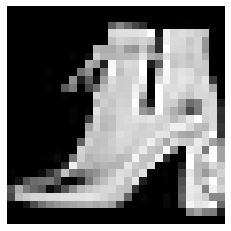

In [6]:
# imshow Taken from Udacity Intro to Machine Learning Course
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        _, ax = plt.subplots()
        
    image = image.transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


imshow(images[0,:])
print(classes[labels[0]])

### Defining the CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) 
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
model = Net()
print(model)
model.cuda()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Will train model on GPU


D:\Users\user\Anaconda3\lib\site-packages\torch\cuda\__init__.py:132: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Loss Function and Optimizer

In [5]:
import torch.optim as optim

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.001)


### Training the Network

In [6]:
# epochs to train for
epochs = 25

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):
    
    train_loss = 0
    valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')
        
    

..\torch\csrc\utils\python_arg_parser.cpp:698: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


Current Epoch: 1
Training Loss: 2.303327
Validation Loss: 2.301204
Validation loss decreased from inf to 2.301204
Current Epoch: 2
Training Loss: 2.299417
Validation Loss: 2.296374
Validation loss decreased from 2.301204 to 2.296374
Current Epoch: 3
Training Loss: 2.294641
Validation Loss: 2.290173
Validation loss decreased from 2.296374 to 2.290173
Current Epoch: 4
Training Loss: 2.28691
Validation Loss: 2.278475
Validation loss decreased from 2.290173 to 2.278475
Current Epoch: 5
Training Loss: 2.271698
Validation Loss: 2.25325
Validation loss decreased from 2.278475 to 2.25325
Current Epoch: 6
Training Loss: 2.231725
Validation Loss: 2.175184
Validation loss decreased from 2.25325 to 2.175184
Current Epoch: 7
Training Loss: 2.0709
Validation Loss: 1.822663
Validation loss decreased from 2.175184 to 1.822663
Current Epoch: 8
Training Loss: 1.649778
Validation Loss: 1.361858
Validation loss decreased from 1.822663 to 1.361858
Current Epoch: 9
Training Loss: 1.378867
Validation Loss: 1

In [6]:
model.load_state_dict(torch.load('trained_model.pt'))

<All keys matched successfully>

### Testing the Network's Accuracy

In [7]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU
    data, target = data.cuda(), target.cuda()
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(28):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {round(test_loss, 6)}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Test Accuracy of {classes[i]}s: N/A (no training examples)')
        
        
print(f'Full Test Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} out of {np.sum(class_total)}')

Test Loss: 0.556627
Test Accuracy of T-shirt/top: 83.09%
Test Accuracy of Trouser: 94.64%
Test Accuracy of Pullover: 68.33%
Test Accuracy of Dress: 85.62%
Test Accuracy of Coat: 70.78%
Test Accuracy of Sandal: 81.63%
Test Accuracy of Shirt: 23.72%
Test Accuracy of Sneaker: 91.83%
Test Accuracy of Bag: 92.39%
Test Accuracy of Ankle boot: 94.04%
Full Test Accuracy: 78.58% 6117.0 out of 7784.0


### Visualizing Results

In [ ]:
# Work in Progress